# Neural Network with Bayesian Optimization for Customer Churn Prediction


This Jupyter Notebook provides steps to preprocess the data, tune hyperparameters using Bayesian Optimization, and train a Neural Network model for customer churn prediction using the processed dataset.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization

## Load and Preprocess the Data

In [2]:
# Load the processed dataset
data_path = './enhanced_feature_data.csv' 
df = pd.read_csv(data_path)
df.drop(['tenure_bins'], axis=1, inplace=True)

# Define the feature columns and the target column
feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns]
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build the Neural Network

In [3]:
# Define the model building function
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Bayesian Optimization

In [4]:
# Set up the Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='bayesian_optimization',
    project_name='churn_model'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping], verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=2)

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.8047914803028107

Best val_accuracy So Far: 0.8132209479808807
Total elapsed time: 00h 01m 18s
Epoch 1/50
141/141 - 1s - 9ms/step - accuracy: 0.7890 - loss: 0.4451 - val_accuracy: 0.8039 - val_loss: 0.4061
Epoch 2/50
141/141 - 0s - 1ms/step - accuracy: 0.8012 - loss: 0.4199 - val_accuracy: 0.7977 - val_loss: 0.4045
Epoch 3/50
141/141 - 0s - 2ms/step - accuracy: 0.8030 - loss: 0.4101 - val_accuracy: 0.7995 - val_loss: 0.4171
Epoch 4/50
141/141 - 0s - 1ms/step - accuracy: 0.8067 - loss: 0.4082 - val_accuracy: 0.8030 - val_loss: 0.4113
Epoch 5/50
141/141 - 0s - 1ms/step - accuracy: 0.8110 - loss: 0.4048 - val_accuracy: 0.8012 - val_loss: 0.4137
Epoch 6/50
141/141 - 0s - 1ms/step - accuracy: 0.8170 - loss: 0.4017 - val_accuracy: 0.7959 - val_loss: 0.4075
Epoch 7/50
141/141 - 0s - 1ms/step - accuracy: 0.8158 - loss: 0.3969 - val_accuracy: 0.7933 - val_loss: 0.4157
Epoch 8/50
141/141 - 0s - 1ms/step - accuracy: 0.8150 - loss: 0.3970 - val_accur

## Evaluate the Model

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.79
Precision: 0.61
Recall: 0.56
F1-Score: 0.58
ROC AUC: 0.83


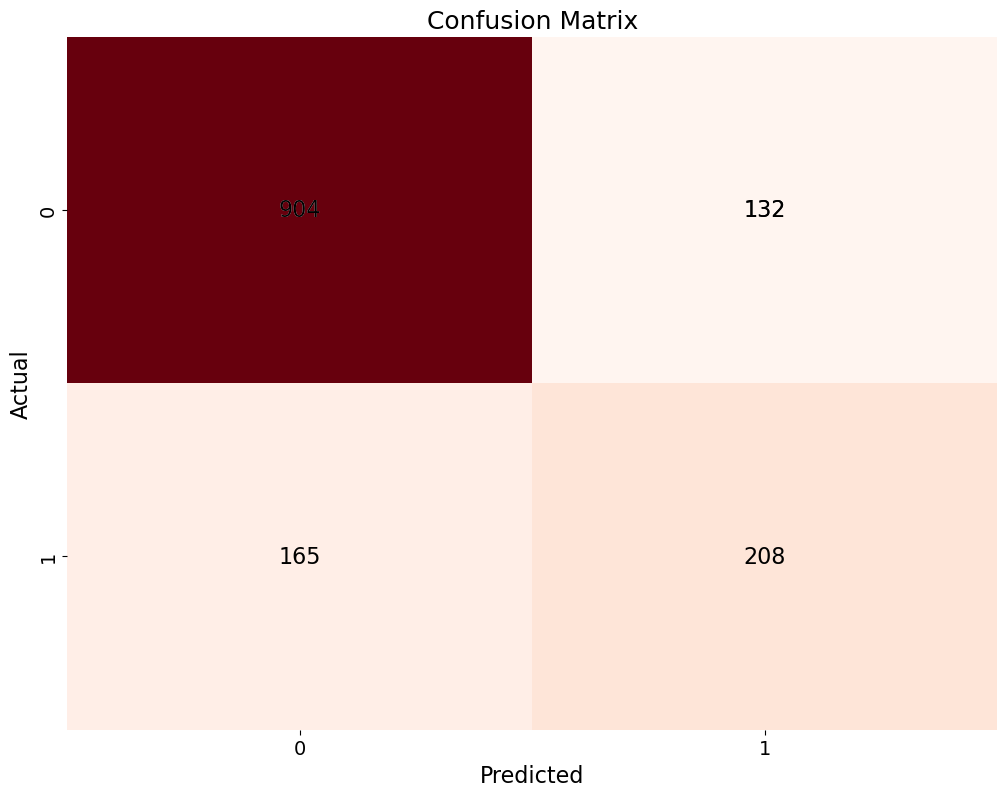

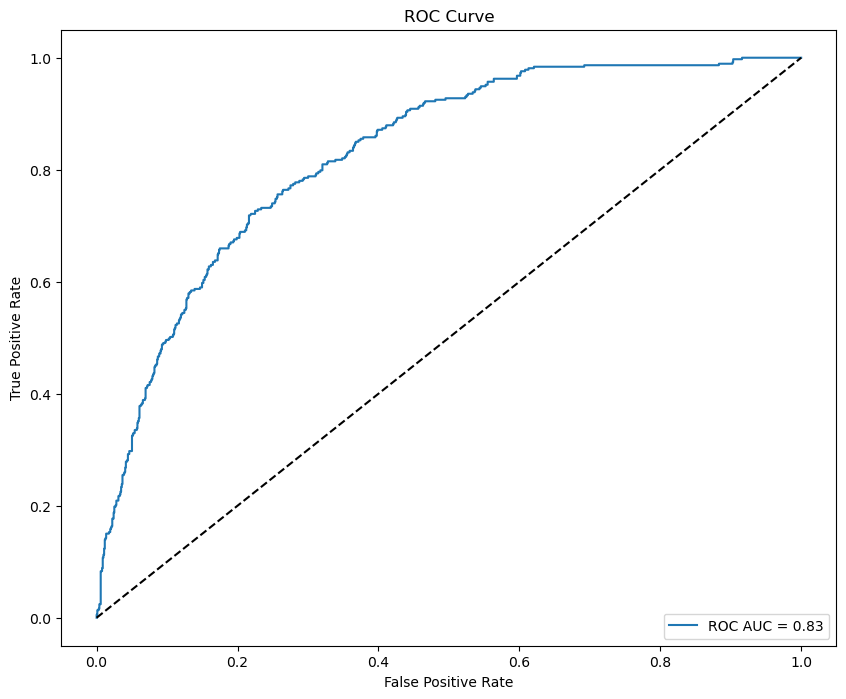

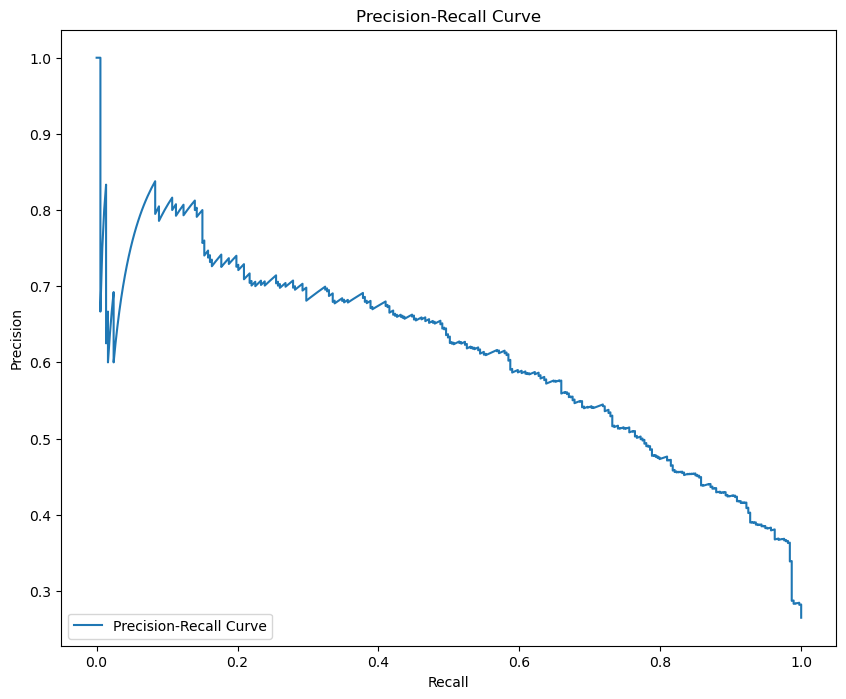

In [5]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Save Results

In [6]:
# Save evaluation metrics to a text file
with open('./nn_bayes_evaluation_metrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.2f}\n')
    f.write(f'Precision: {precision:.2f}\n')
    f.write(f'Recall: {recall:.2f}\n')
    f.write(f'F1-Score: {f1:.2f}\n')
    f.write(f'ROC AUC: {roc_auc:.2f}\n')

# Save classification report to a text file
class_report = classification_report(y_test, y_pred)
with open('./nn_bayes_classification_report.txt', 'w') as f:
    f.write(class_report)
    
# Save confusion matrix as an image
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./NN_bayes_ConfusionMatrix.png')
plt.close()

In [9]:
# Save the Model
model_filename = 'NN_bayes_churn_model_optimized.keras'
model.save(model_filename) 
print(f'Model saved to {model_filename}')

Model saved to NN_bayes_churn_model_optimized.keras
